In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Thường xuyên dùng cho activation function
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split # Cần cho bước chia data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Cần cho bước Evaluation (Heatmap)
from sklearn.metrics import classification_report, confusion_matrix # Cần cho Evaluation
import random
import os

# 1. Cấu hình thiết bị (Dynamic Device)
# Tự động chọn GPU nếu có, nếu không thì dùng CPU.
# Trên Colab: Vào Runtime -> Change runtime type -> T4 GPU để kích hoạt.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on Device: {device}")

# 2. Reproducibility Setup
def seed_everything(seed=42):
    """
    Khóa random state cho cả CPU và GPU để đảm bảo kết quả giống hệt nhau mỗi lần chạy.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Cấu hình cho GPU (Nếu có)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # 2 dòng này làm chậm tốc độ một chút nhưng đảm bảo tính xác định (Deterministic)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)
print(f"Global Seed set to 42. Environment is ready.")

Running on Device: cuda
Global Seed set to 42. Environment is ready.


In [2]:
# === CELL 2: DATA ENGINEERING (UPDATED & FIXED) ===
from torch.utils.data import Subset

# 1. Hyperparameters
BATCH_SIZE = 64

# 2. Define Transforms
# Train: Heavy Augmentation (Quan trọng cho vẽ tay thực tế)
train_transform = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,             # Xoay +/- 15 độ
        translate=(0.2, 0.2),   # Dịch chuyển 20% (Giúp nhận diện số viết lệch tâm)
        scale=(0.8, 1.2)        # Phóng to/Thu nhỏ 20% (Giúp nhận diện nét to/nhỏ)
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean/Std chuẩn của MNIST
])

# Test/Val: Clean (Chỉ chuẩn hóa, không biến đổi hình học)
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 3. Download & Split Data
# Mẹo kỹ thuật: Load dataset 2 lần với 2 transform khác nhau
# Để đảm bảo Train thì "Khó" (Augmented), còn Val thì "Sạch" (Clean)
full_train_aug = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
full_train_clean = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=val_test_transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=val_test_transform)

# Tạo indices để chia tách (Đảm bảo không trùng lặp)
# Tổng: 60,000 ảnh. Train: 48,000 (80%), Val: 12,000 (20%)
indices = list(range(len(full_train_aug)))
# Không cần shuffle ở đây vì đã có seed_everything, ta sẽ shuffle trong DataLoader
split = int(0.8 * len(full_train_aug))
train_indices = indices[:split]
val_indices = indices[split:]

# Tạo Subset:
# - Train lấy từ tập Augmented
train_dataset = Subset(full_train_aug, train_indices)
# - Val lấy từ tập Clean
val_dataset = Subset(full_train_clean, val_indices)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset Stats (Clean Split):")
print(f"- Train samples (Augmented): {len(train_dataset)}")
print(f"- Val samples (Clean):       {len(val_dataset)}")
print(f"- Test samples:              {len(test_dataset)}")
# Kiểm tra nhanh 1 sample
img, label = train_dataset[0]
print(f"- Input Shape:   {img.shape} (C, H, W)")
print(f"- Normalization: Mean={img.mean():.4f}, Std={img.std():.4f}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.52MB/s]


Dataset Stats (Clean Split):
- Train samples (Augmented): 48000
- Val samples (Clean):       12000
- Test samples:              10000
- Input Shape:   torch.Size([1, 28, 28]) (C, H, W)
- Normalization: Mean=0.1613, Std=1.1219


Label của 8 ảnh đầu tiên: [9 3 3 9 0 2 4 4]
Hãy quan sát kỹ: Ảnh có bị xoay, dịch chuyển hay co giãn không?


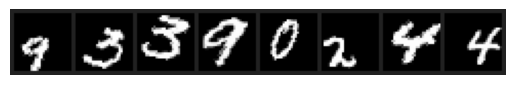

In [3]:
# === CELL 3: VISUALIZATION & SANITY CHECK ===
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 1. Lấy 1 batch từ Train Loader
# iter() tạo iterator, next() lấy batch đầu tiên
data_iter = iter(train_loader)
images, labels = next(data_iter)

# 2. Hàm helper hiển thị ảnh
def imshow(img):
    # Unnormalize: Đưa tensor từ distribution chuẩn về lại [0, 1] để mắt người xem được
    # Công thức ngược: X_new = X_old * Std + Mean
    img = img * 0.3081 + 0.1307

    # Kẹp giá trị (Clamp) để đảm bảo không có pixel nào < 0 hoặc > 1 do sai số
    img = torch.clamp(img, 0, 1)

    npimg = img.numpy()
    # Chuyển chiều: PyTorch (C, H, W) -> Matplotlib (H, W, C)
    plt.axis('off') # Tắt trục tọa độ cho đẹp
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# 3. Hiển thị Grid
print("Label của 8 ảnh đầu tiên:", labels[:8].numpy())
print("Hãy quan sát kỹ: Ảnh có bị xoay, dịch chuyển hay co giãn không?")

# make_grid ghép các ảnh thành 1 tấm lưới
imshow(torchvision.utils.make_grid(images[:8], nrow=8))

In [4]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # Khối 1: Feature Extraction (Input 1 -> Output 32)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # Giúp model hội tụ nhanh hơn, ổn định hơn
            nn.ReLU(),          # Hàm kích hoạt phi tuyến tính
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Khối 2: Feature Extraction (Input 32 -> Output 64)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Khối 3: Classification (Fully Connected)
        # Flatten size = 64 * 7 * 7 = 3136 (như đã tính)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64 * 7 * 7, out_features=128), # Hidden layer
            nn.ReLU(),
            nn.Dropout(0.5), # Kỹ thuật Regularization: tắt ngẫu nhiên 50% neuron để chống overfitting
            nn.Linear(in_features=128, out_features=10) # Output layer (10 số từ 0-9)
        )

    def forward(self, x):
        # Định nghĩa luồng dữ liệu đi qua mạng
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

# Khởi tạo model và đưa vào device (CPU)
model = MyCNN().to(device)
print(model)

MyCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
dummy_input = torch.randn(1, 1, 28, 28).to(device)

# Thử đưa qua model
try:
    output = model(dummy_input)
    print("✅ Model Forward Pass Successful!")
    print(f"Input Shape:  {dummy_input.shape}")
    print(f"Output Shape: {output.shape} (Mong đợi: [1, 10])")
except Exception as e:
    print("❌ Error:", e)

✅ Model Forward Pass Successful!
Input Shape:  torch.Size([1, 1, 28, 28])
Output Shape: torch.Size([1, 10]) (Mong đợi: [1, 10])


In [6]:
# === CELL 6: HYPERPARAMETERS & OPTIMIZER CONFIG ===

# 1. Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 15  # Tăng lên 15 vì ta dùng Heavy Augmentation (Bài toán khó hơn)

# 2. Loss Function & Optimizer
# CrossEntropyLoss đã bao gồm LogSoftmax + NLLLoss bên trong
criterion = nn.CrossEntropyLoss()

# Adam là lựa chọn tốt nhất để bắt đầu (Adaptive Learning Rate)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Learning Rate Scheduler (NÂNG CẤP)
# Giảm Learning Rate đi 10 lần sau mỗi 5 epochs
# Ví dụ: Epoch 1-5: LR=0.001 -> Epoch 6-10: LR=0.0001 -> ...
# Giúp model hội tụ tinh vi hơn ở giai đoạn cuối
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 4. History Tracking containers
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"Ready to train for {EPOCHS} Epochs with StepLR Scheduler.")

Ready to train for 15 Epochs with StepLR Scheduler.


In [7]:
# === CELL 7: MAIN TRAINING LOOP ===
import time

# Khởi tạo biến lưu trữ model tốt nhất
best_val_acc = 0.0

print(f"🚀 Start Training for {EPOCHS} Epochs...")
start_time = time.time()

for epoch in range(EPOCHS):
    # ==========================
    # 1. TRAINING PHASE
    # ==========================
    model.train()  # Bật chế độ Train (Dropout on, BatchNorm update)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # A. Zero Gradients
        optimizer.zero_grad()

        # B. Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # C. Backward Pass
        loss.backward()

        # D. Optimizer Step
        optimizer.step()

        # Thống kê
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Tính trung bình Loss và Accuracy cho Epoch này
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train

    # ==========================
    # 2. VALIDATION PHASE
    # ==========================
    model.eval() # Bật chế độ Eval (Dropout off, BatchNorm frozen)
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Tắt gradient để tiết kiệm RAM
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = 100 * correct_val / total_val

    # ==========================
    # 3. SCHEDULER & LOGGING
    # ==========================
    # Cập nhật Learning Rate sau mỗi Epoch (Quan trọng!)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Lưu lịch sử
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_train_acc)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | LR: {current_lr:.6f} | "
          f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}%")

    # ==========================
    # 4. CHECKPOINTING (BEST MODEL)
    # ==========================
    if epoch_val_acc > best_val_acc:
        print(f"--> 🌟 Improvement! Saving model ({best_val_acc:.2f}% -> {epoch_val_acc:.2f}%)")
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_mnist_model.pth')

total_time = time.time() - start_time
print(f"\n✅ Training Completed in {total_time:.2f}s. Best Val Acc: {best_val_acc:.2f}%")

🚀 Start Training for 15 Epochs...
Epoch 1/15 | LR: 0.001000 | Train Loss: 1.0417 | Acc: 63.48% | Val Loss: 0.1359 | Acc: 96.15%
--> 🌟 Improvement! Saving model (0.00% -> 96.15%)
Epoch 2/15 | LR: 0.001000 | Train Loss: 0.5892 | Acc: 80.22% | Val Loss: 0.0993 | Acc: 96.90%
--> 🌟 Improvement! Saving model (96.15% -> 96.90%)
Epoch 3/15 | LR: 0.001000 | Train Loss: 0.4682 | Acc: 84.68% | Val Loss: 0.1122 | Acc: 96.63%
Epoch 4/15 | LR: 0.001000 | Train Loss: 0.4134 | Acc: 86.46% | Val Loss: 0.0793 | Acc: 97.59%
--> 🌟 Improvement! Saving model (96.90% -> 97.59%)
Epoch 5/15 | LR: 0.000100 | Train Loss: 0.3845 | Acc: 87.59% | Val Loss: 0.0863 | Acc: 97.38%
Epoch 6/15 | LR: 0.000100 | Train Loss: 0.3119 | Acc: 90.13% | Val Loss: 0.0604 | Acc: 98.12%
--> 🌟 Improvement! Saving model (97.59% -> 98.12%)
Epoch 7/15 | LR: 0.000100 | Train Loss: 0.2994 | Acc: 90.63% | Val Loss: 0.0589 | Acc: 98.16%
--> 🌟 Improvement! Saving model (98.12% -> 98.16%)
Epoch 8/15 | LR: 0.000100 | Train Loss: 0.2894 | Acc: 

In [8]:
# === CELL 8: SAVE & DOWNLOAD MODEL ===
from google.colab import files
import os

# 1. Định nghĩa tên file
best_model_path = 'best_mnist_model.pth' # File này đã được lưu tự động trong vòng lặp Training
last_model_path = 'last_mnist_model.pth'

# 2. Lưu thêm model ở epoch cuối cùng (để dự phòng hoặc train tiếp sau này)
torch.save(model.state_dict(), last_model_path)
print(f"✅ Đã lưu model cuối cùng (Epoch {EPOCHS}): {last_model_path}")

# 3. Kiểm tra xem file Best Model có tồn tại không (phòng trường hợp train lỗi chưa lưu)
if os.path.exists(best_model_path):
    print(f"✅ Tìm thấy Best Model: {best_model_path}")
    print("⬇️ Đang tải xuống Best Model (Dùng file này để nộp bài hoặc deploy)...")
    files.download(best_model_path)
else:
    print("⚠️ Không tìm thấy Best Model. Đang tải model cuối cùng thay thế.")
    files.download(last_model_path)

✅ Đã lưu model cuối cùng (Epoch 15): last_mnist_model.pth
✅ Tìm thấy Best Model: best_mnist_model.pth
⬇️ Đang tải xuống Best Model (Dùng file này để nộp bài hoặc deploy)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

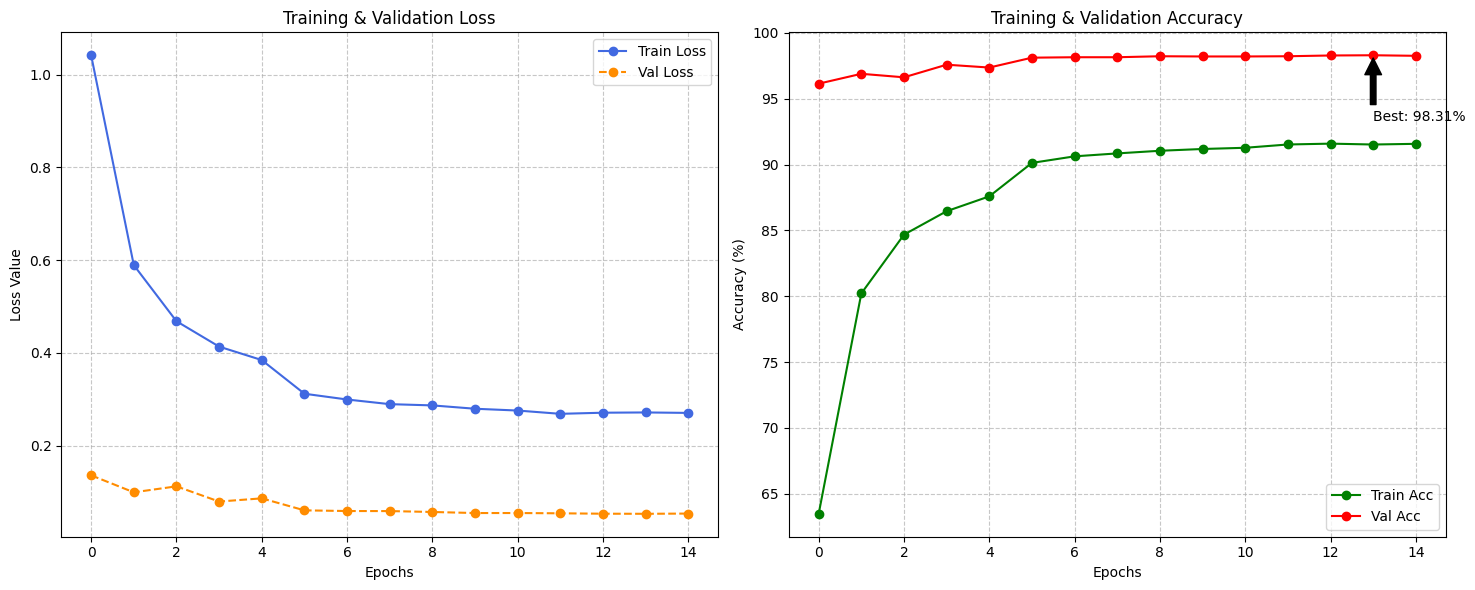

In [9]:
# === CELL 9: VISUALIZATION (ADVANCED) ===
import matplotlib.pyplot as plt

# Cấu hình kích thước ảnh to hơn cho dễ nhìn
plt.figure(figsize=(15, 6))

# 1. Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='royalblue', marker='o', linestyle='-')
plt.plot(val_losses, label='Val Loss', color='darkorange', marker='o', linestyle='--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.grid(True, linestyle='--', alpha=0.7) # Thêm lưới mờ
plt.legend()

# 2. Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='green', marker='o')
plt.plot(val_accs, label='Val Acc', color='red', marker='o')

# Đánh dấu điểm cao nhất (Best Val Acc)
max_val_acc = max(val_accs)
max_epoch = val_accs.index(max_val_acc)
plt.annotate(f'Best: {max_val_acc:.2f}%',
             xy=(max_epoch, max_val_acc),
             xytext=(max_epoch, max_val_acc - 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0     0.9837    0.9878    0.9857       980
           1     0.9921    0.9947    0.9934      1135
           2     0.9827    0.9893    0.9860      1032
           3     0.9911    0.9911    0.9911      1010
           4     0.9787    0.9817    0.9802       982
           5     0.9899    0.9899    0.9899       892
           6     0.9814    0.9927    0.9870       958
           7     0.9864    0.9854    0.9859      1028
           8     0.9937    0.9723    0.9829       974
           9     0.9761    0.9703    0.9732      1009

    accuracy                         0.9856     10000
   macro avg     0.9856    0.9855    0.9855     10000
weighted avg     0.9856    0.9856    0.9856     10000



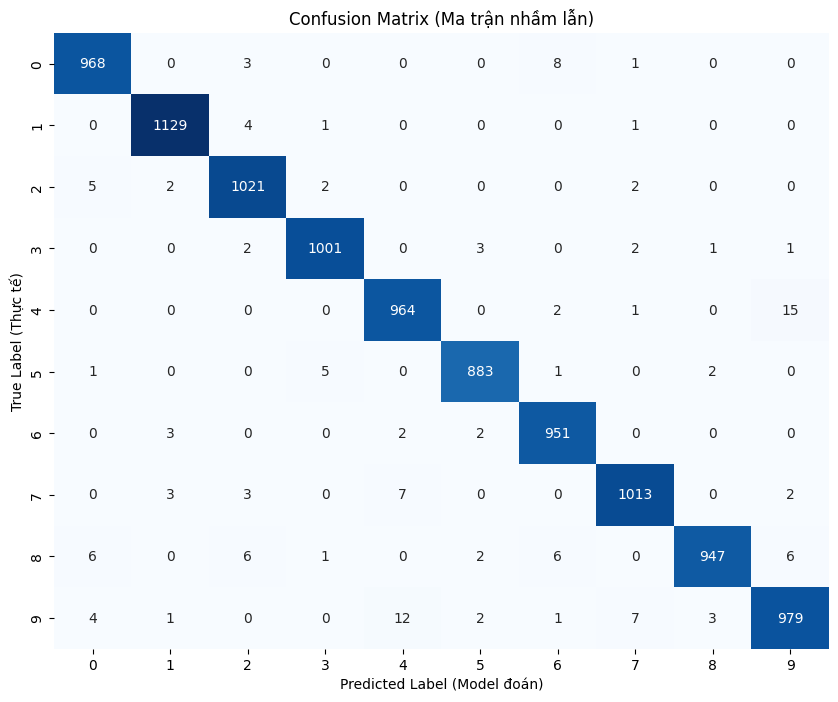

In [10]:
# === CELL 10: EVALUATION WITH SKLEARN & SEABORN ===
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# 1. Thu thập toàn bộ dự đoán trên tập Test
# Lưu ý: Phải chuyển dữ liệu từ GPU về CPU để Scikit-learn xử lý
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Lấy nhãn dự đoán (Max Probability)
        _, predicted = torch.max(outputs, 1)

        # Đưa về CPU và list
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 2. In báo cáo chi tiết (Precision, Recall, F1-Score)
print("=== CLASSIFICATION REPORT ===")
# target_names giúp báo cáo dễ đọc hơn
print(classification_report(y_true, y_pred, digits=4))

# 3. Vẽ Confusion Matrix (Heatmap)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
# fmt='d': Hiển thị số nguyên (không dùng 1e2...)
# cmap='Blues': Tông màu xanh chuyên nghiệp
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix (Ma trận nhầm lẫn)')
plt.xlabel('Predicted Label (Model đoán)')
plt.ylabel('True Label (Thực tế)')
plt.show()

In [12]:
# === CELL: EXPORT RESULTS & CREATE FULL PACKAGE ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from google.colab import files
import zipfile
import os

print("🔄 Đang tạo báo cáo và lưu file...")

# 1. LƯU BIỂU ĐỒ TRAINING (LOSS & ACCURACY)
# Giả định các biến train_losses, val_losses... vẫn còn trong RAM
if 'train_losses' in globals() and len(train_losses) > 0:
    plt.figure(figsize=(15, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='royalblue')
    plt.plot(val_losses, label='Val Loss', color='darkorange', linestyle='--')
    plt.title('Training Dynamics - Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='green')
    plt.plot(val_accs, label='Val Acc', color='red', linestyle='--')
    plt.title('Training Dynamics - Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid(True, alpha=0.3)

    # Lưu ảnh (DPI 300 để in ấn sắc nét)
    plt.savefig('training_curves.png', dpi=300)
    plt.close() # Đóng plot để không hiện lại lên màn hình
    print("✅ Đã lưu: training_curves.png")
else:
    print("⚠️ Không tìm thấy lịch sử training trong RAM, bỏ qua biểu đồ.")

# 2. LƯU ĐÁNH GIÁ TRÊN TẬP TEST (REPORT & CONFUSION MATRIX)
# Chạy lại đánh giá trên tập Test
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# A. Lưu Classification Report (Text file)
report = classification_report(y_true, y_pred, digits=4)
with open('evaluation_report.txt', 'w') as f:
    f.write("=== MNIST MODEL EVALUATION REPORT ===\n")
    f.write(f"Model Architecture: Custom CNN (2 Conv Blocks + FC)\n")
    f.write(f"Test Set Size: {len(test_dataset)}\n")
    f.write("=====================================\n\n")
    f.write(report)
print("✅ Đã lưu: evaluation_report.txt")

# B. Lưu Confusion Matrix (Image file)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.close()
print("✅ Đã lưu: confusion_matrix.png")

# 3. ĐÓNG GÓI TOÀN BỘ (CODE + MODEL + REPORT)
# Sử dụng lại file app.py và requirements.txt đã tạo ở bước trước
files_to_zip = [
    'app.py',
    'requirements.txt',
    'best_mnist_model.pth',
    'training_curves.png',
    'confusion_matrix.png',
    'evaluation_report.txt'
]

zip_name = "mnist_project_full.zip"
with zipfile.ZipFile(zip_name, 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)
            print(f"  -> Đã nén: {file}")
        else:
            print(f"  ⚠️ Thiếu file: {file}")

print(f"\n📦 Đã đóng gói xong: {zip_name}")
files.download(zip_name)

🔄 Đang tạo báo cáo và lưu file...
✅ Đã lưu: training_curves.png
✅ Đã lưu: evaluation_report.txt
✅ Đã lưu: confusion_matrix.png
  ⚠️ Thiếu file: app.py
  ⚠️ Thiếu file: requirements.txt
  -> Đã nén: best_mnist_model.pth
  -> Đã nén: training_curves.png
  -> Đã nén: confusion_matrix.png
  -> Đã nén: evaluation_report.txt

📦 Đã đóng gói xong: mnist_project_full.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>